<a href="https://colab.research.google.com/github/ayrna/deep-learning-with-python-notebooks/blob/master/chapter03_introduction-to-keras-and-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

> This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.
> **If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**
> This notebook was generated for TensorFlow 2.6.

# Introducción a Keras y TensorFlow

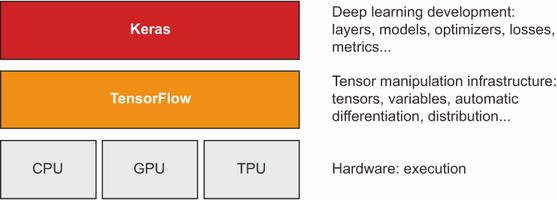

Keras acaba de publicar como estable la versión 3.0, que incluye más "motores" de deep learning además de TensorFLow.

https://keras.io/

Puede interesarte mirar la galería de ejemplos:

https://keras.io/examples/

## Primeros pasos con TensorFlow

Entrenar redes neuronales gira en torno a varios conceptos:

1. La manipulación de tensores, la *infraestructura* que subyace a todo el aprendizaje automático moderno. Esto se traduce en las APIs de **TensorFlow**:
 * *Tensores*, incluyendo tensores especiales que almacenan el estado de la red (variables)
 * *Operaciones de tensor* como la `suma`, `relu`, `matmul`
 * *Retropropagación (Backpropagation)*, una forma de calcular el gradiente de expresiones matemáticas (usado TensorFlow a través del objeto `GradientTape`)
2. Conceptos de aprendizaje profundo de alto nivel. Esto se traduce en las APIs de **Keras**:
 * *Capas*, que se combinan en un modelo
 * *Función de pérdida*, que define la señal de retroalimentación utilizada para el aprendizaje
 * *Optimizador*, que determina cómo se realiza el ajuste/aprendizaje a los datos.
 * *Métricas* para evaluar el rendimiento del modelo, como la precisión
 * Un *bucle de entrenamiento* que realiza el descenso de gradiente estocástico en mini lotes

#### Tensores constantes y variables

Los tensores son la estructura de datos básica de TensorFlow y Keras. Deben crearse con un contenido y no se les puede asignar un valor.

Cuando es necesario cambiar el estado de una variable necesitaremos el tipo `tf.Variable`, que deben crearse con un valor inicial también.

**All-ones o all-zeros tensors**

In [1]:
cx = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Tensores aleatorios**

In [3]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[ 0.63993037]
 [ 0.51455307]
 [-0.8537113 ]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.02488983]
 [0.8555727 ]
 [0.94667363]], shape=(3, 1), dtype=float32)


**Los arrays de NumPy son asignables pero los tensores no**

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [6]:
try:
  x = tf.ones(shape=(2, 2))
  x[0, 0] = 0.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


**Crear un TensorFlow variable**

In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.5663697 ],
       [ 0.15519804],
       [-0.9310002 ]], dtype=float32)>


**Asignar un valor a un TensorFlow variable**

In [8]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Asignar un valor a un subconjunto de un TensorFlow variable**

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Suma con `assign_add`**

In [10]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Operaciones matemáticas con Tensores

**Operaciones básicas**

In [11]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### GradientTape API

**Cómo usar `GradientTape`**

Basta con abrir un *ámbito* de `GradientTape`, aplicar algún cálculo a uno o varios tensores de entrada, y recuperar el gradiente del resultado con respecto a las entradas.

$f(x)=x^2$

$
\frac{\partial f}{\partial x} = 2x
$



In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
# la función sería f(x)=x^2; f'(x)=2x, siendo x = 3 f'(x)=6
print(input_var)
print(gradient)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
tf.Tensor(6.0, shape=(), dtype=float32)


**`GradientTape` con tensores constantes como entrada**

Hasta ahora, sólo hemos visto el caso en que los tensores de entrada en `tape.gradient()` eran variables TensorFlow. En realidad es posible que estas entradas sean cualquier tensor arbitrario. Sin embargo, sólo las variables entrenables son *rastreadas* por defecto. Con un tensor constante, hay que marcarlo manualmente como rastreado llamando a `tape.watch()` sobre él. Esto se hace por motivos de eficiencia computacional.

In [13]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(result)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


#### Un clasificador lineal completo en TensorFlow

**Generación del conjunto de datos**

In [14]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [15]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [16]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

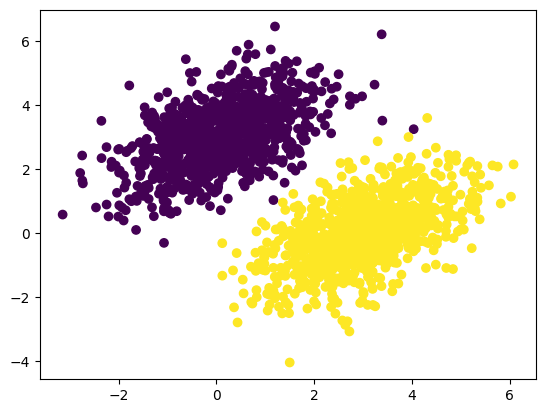

In [17]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creación de la variables del modelo lineal**

Inicializamos `W` con valores aleatorios y `b` a cero.


In [26]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**Propagación hacia delante**

In [19]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**Función de pérdia de error cuadrático medio (MSE)**

* `persample_loss` es un tensor con la misma forma que targets y predictions y almacenará la pérdida correspondiente a cada patrón.
* Devolvemos la contribución media al error del lote. `reduce_mean` por defecto reduce todas las dimensiones a 1, pero podría utilizarse para calcular medias por ejes del tensor.

In [20]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**El paso de entrenamiento**

Recordad que `GradientTape` nos permite derivar respecto a listas de parámetros. En este caso nos devuelve el gradiente parcial respecto a cada parámetro de la lista.

In [21]:
learning_rate = 0.01

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**Bucle de aprendizaje con el conjunto completo (batch training)**

Para simplificar, haremos un entrenamiento por lotes en lugar de un mini-entrenamiento por lotes: ejecutaremos cada paso de entrenamiento (cálculo del gradiente y actualización de pesos) para todos los datos, en lugar de iterar sobre los datos en pequeños lotes.

Esto significa que cada paso de entrenamiento tardará mucho más tiempo en ejecutarse pero cada actualización del gradiente será mucho más eficaz para reducir la función de pérdida al incluir todos los datos de entrenamiento. Esto significa que harán falta menos pasos de entrenamiento y que la tasa de aprendizaje debería ser mayor que al utilizar lotes pequeños (`learning_rate = 0.1`).

❓❓❓ **EJERCICIO**
* Prueba a utilizar distintas tasas de aprendizaje en este ejemplo y observa el resultado
* ¿[Tiene sentido que la tasa de aprendizaje sea mayor que 1](https://ai.stackexchange.com/questions/23740/why-is-the-learning-rate-generally-beneath-1)?
* Intenta programar otra función de pérdida: el RMSE.

❓❓❓

In [22]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.2613
Loss at step 1: 2.4729
Loss at step 2: 1.8852
Loss at step 3: 1.4468
Loss at step 4: 1.1194
Loss at step 5: 0.8748
Loss at step 6: 0.6918
Loss at step 7: 0.5548
Loss at step 8: 0.4519
Loss at step 9: 0.3747
Loss at step 10: 0.3165
Loss at step 11: 0.2726
Loss at step 12: 0.2393
Loss at step 13: 0.2141
Loss at step 14: 0.1948
Loss at step 15: 0.1801
Loss at step 16: 0.1687
Loss at step 17: 0.1598
Loss at step 18: 0.1529
Loss at step 19: 0.1474
Loss at step 20: 0.1430
Loss at step 21: 0.1394
Loss at step 22: 0.1365
Loss at step 23: 0.1340
Loss at step 24: 0.1319
Loss at step 25: 0.1301
Loss at step 26: 0.1285
Loss at step 27: 0.1271
Loss at step 28: 0.1257
Loss at step 29: 0.1245
Loss at step 30: 0.1234
Loss at step 31: 0.1223
Loss at step 32: 0.1213
Loss at step 33: 0.1203
Loss at step 34: 0.1194
Loss at step 35: 0.1185
Loss at step 36: 0.1176
Loss at step 37: 0.1167
Loss at step 38: 0.1158
Loss at step 39: 0.1150


In [23]:
def rmse_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.sqrt(tf.reduce_mean(per_sample_losses))

In [35]:
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = rmse_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

lr = 0.01
lr = 0.05
lr = 0.1
lr = 0.5
lr = 1
lr = 1.5


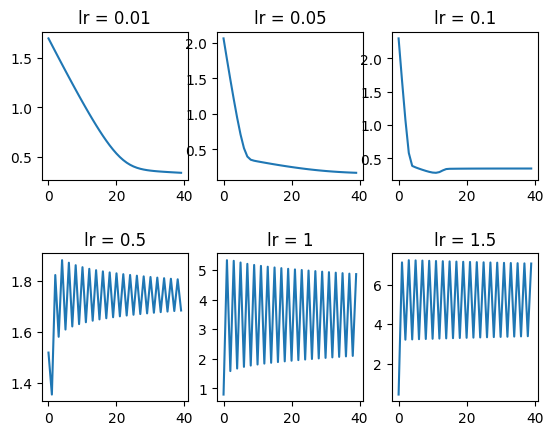

In [37]:
list_learning_rate = [0.01, 0.05, 0.1, 0.5, 1, 1.5]
plot = list(list())
for learning_rate in list_learning_rate:
  print(f"lr = {learning_rate}")
  W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
  b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))
  loss_list = list()
  for step in range(40):
      loss = training_step(inputs, targets)
      loss_list.append(loss)
      #print(f"Loss at step {step}: {loss:.4f}")
  plot.append(loss_list)

# graficamos el loss en todos los learning rates
for i in range(len(plot)):
  plt.subplot(2, 3, i+1)
  plt.title(f"lr = {list_learning_rate[i]}")
  plt.subplots_adjust(hspace=0.5)
  plt.plot(plot[i])


La tasa de aprendizaje o learning rate se encarga de controlar los pasos que el algoritmo de optimización da durante el entrenamiento en el espacio de los pesos de la red. Si la tasa de aprendizaje es demasiado grande (>1) estos pasos pueden ser tan grandes que el algoritmo diverge y la función de pérdida se dispara (como se puede observar en las gráficas lr=0.5, lr=1 y lr=1.5). Sin embargo, si la tasa es demasiado pequeña (lr = 0.01) el algoritmo puede tardar demasiado en converger o caer en un óptimo local.

Lo ideal es probar con varios valores de tasa de aprendizaje y comprobar cuál se comporta mejor con nuestro modelo para poder utilizarlo.

Como vemos la función de pérdida más o menos se estabiliza.

Ahora vamos a predecir la clase de los patrones. En este ejemplo de clasificación binaria el umbral de decisión entre las clases es `0.5` donde se asigna la clase "1" para los valores mayores que el umbral.

Loss at step 0: 1.6501
Loss at step 1: 1.3362
Loss at step 2: 1.0350
Loss at step 3: 0.7574
Loss at step 4: 0.5290
Loss at step 5: 0.3952
Loss at step 6: 0.3569
Loss at step 7: 0.3453
Loss at step 8: 0.3362
Loss at step 9: 0.3274
Loss at step 10: 0.3187
Loss at step 11: 0.3102
Loss at step 12: 0.3019
Loss at step 13: 0.2937
Loss at step 14: 0.2857
Loss at step 15: 0.2779
Loss at step 16: 0.2703
Loss at step 17: 0.2628
Loss at step 18: 0.2556
Loss at step 19: 0.2487
Loss at step 20: 0.2420
Loss at step 21: 0.2355
Loss at step 22: 0.2293
Loss at step 23: 0.2234
Loss at step 24: 0.2177
Loss at step 25: 0.2124
Loss at step 26: 0.2073
Loss at step 27: 0.2026
Loss at step 28: 0.1982
Loss at step 29: 0.1940
Loss at step 30: 0.1902
Loss at step 31: 0.1867
Loss at step 32: 0.1834
Loss at step 33: 0.1805
Loss at step 34: 0.1778
Loss at step 35: 0.1753
Loss at step 36: 0.1731
Loss at step 37: 0.1712
Loss at step 38: 0.1694
Loss at step 39: 0.1678


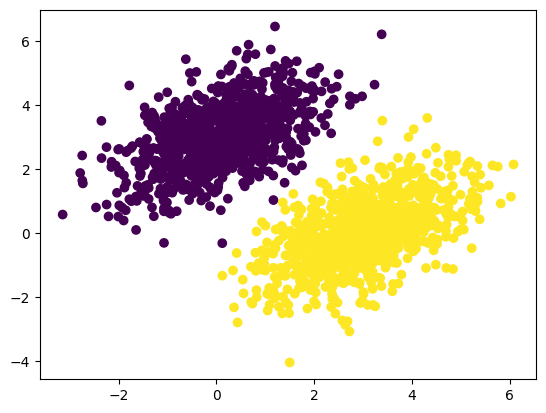

In [45]:
learning_rate = 0.05
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

for step in range(40):
      loss = training_step(inputs, targets)
      print(f"Loss at step {step}: {loss:.4f}")

predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

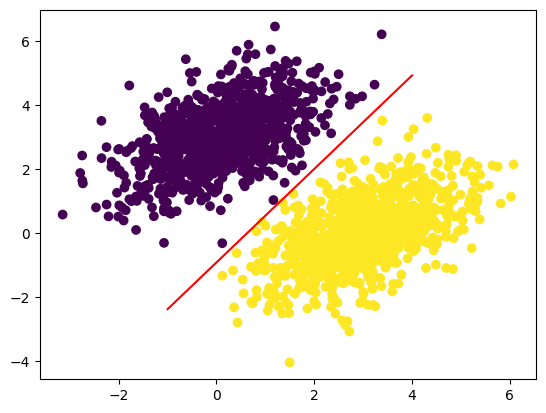

In [46]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomía de una red neuronal para entender conceptos de Keras

### Capas (Layers)

La estructura de datos fundamental en las redes neuronales es la *capa*. Una capa es un módulo de procesamiento de datos que toma como entrada uno o más tensores y que da como salida uno o más tensores. Algunas capas no tienen estado, pero lo más frecuente es que las capas tengan un estado: los *pesos* de la capa, uno o varios tensores aprendidos con el descenso por gradiente, que en conjunto almacenan el *conocimiento* de la red.

Según el tipo de dato con el que trabajemos habrá tipos de capas más apropiados para trabajar con estos.
* Datos vectoriales simples, también llamados tabulares ("hoja de cálculo"), almacenados en tensores de rango 2 `(muestra, características)`, suelen ser procesados por capas densamente conectadas, también llamadas capas totalmente conectadas (la clase `Dense` en Keras).
* Los datos con disposición temporal o de secuencia, tensores de rango 3 `(muestras, pasos de tiempo, características)`, se procesan normalmente por capas recurrentes, como una capa `LSTM`, o capas de convolución 1D (`Conv1D`).
* Los datos de imágenes, almacenados en tensores de rango 4, suelen ser procesados por capas de convolución 2D (`Conv2D`).

#### La clase `Layer` en Keras


Casi todo en Keras gira en torno a un objeto de tipo Layer, que encapsula un estado de los pesos y un cálculo sobre la red (*forward pass*). Los pesos se definen en `build()` y el procesamiento en `call()`.


**Una capa `Dense` implementada como subclase de `Layer`**

In [47]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

Esta capa que hemos creado se puede instanciar y usarse como una función:

In [48]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [49]:
my_dense = SimpleDense(units=512, activation=tf.nn.tanh)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 512)


#### Deducción de la forma de la capa automática: construcción de capas sobre la marcha

En Keras en general sólo necesitaremos especificar la forma de los tensores de salida de la capa, ya que las capas que se añaden al modelo se construyen dinámicamente para adaptar cada capa a la forma de la capa de entrada (la salida de la capa anterior).

La siguiente capa sólo puede conectarse a una capa que espere vectores de 32 dimensiones como entrada.

In [50]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

En Keras, no se implementa la construcción de la capa del todo en el constructor `__build__()` en espera de conocer cuál será la forma de la entrada desde la capa anterior.

In [51]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

En el ejemplo de red que hicimos desde cero necesitábamos especificar perfectamente las dimensiones de entrada y salida de la secuencia de capas:

```
model = NaiveSequential([
    NaiveDense(input_size=784, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=10, activation="softmax")
])
```



En Keras basta con lo siguiente:

In [52]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(1, activation="softmax")
])

### De las capas a los modelos

Un modelo de aprendizaje profundo consiste en un grafo de capas, clase `Model` en Keras. Hasta ahora sólo hemos visto el modelo `Sequential`, que es una subclase de `Model` pero existen muchas otras topologías de red más avanzadas (Transformers, [`Residual`](https://keras.io/api/applications/resnet/)...)

### El paso "compile" para configurar el proceso de aprendizaje

Aquí vamos a configurar:
* Función de pérdida (o función objetivo).
* El optimizador.
* Métricas de evaluación sobre el conjunto de train y opcionalmente validación.

Hay dos alternativas para especificar esto:

In [53]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [54]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### La importancia de la función de pérdida ❗❗❗❗

La elección de la función de pérdida correcta para el problema adecuado es extremadamente importante: la red tomará cualquier atajo que pueda para minimizar la pérdida, por lo que si el objetivo no está totalmente correlacionado con la tarea en cuestión, la red terminará haciendo cosas que probablemente no queramos.

Ejemplos:
* ¿detector de emociones?
* ¿maximizar el bienestar promedio de los seres humanos?
* [Hundreds of AI tools have been built to catch covid. None of them helped.](https://www.technologyreview.com/2021/07/30/1030329/machine-learning-ai-failed-covid-hospital-diagnosis-pandemic/)
* [Leakage and the reproducibility crisis in machine-learning-based science](https://www.sciencedirect.com/science/article/pii/S2666389923001599)

### El método fit()

**Calling `fit()` with NumPy data**

In [55]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5483 - loss: 9.3473  
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.5483 - loss: 8.6446 
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5676 - loss: 8.5051 
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.5521 - loss: 8.1623 
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5543 - loss: 7.6099 


In [56]:
history.history

{'binary_accuracy': [0.5444999933242798,
  0.5485000014305115,
  0.5529999732971191,
  0.5554999709129333,
  0.5590000152587891],
 'loss': [9.228705406188965,
  8.743416786193848,
  8.337117195129395,
  7.9489874839782715,
  7.5694580078125]}

### Monitorización de la pérdida y las métricas sobre datos de validación

**Parámetro `validation_data`**


In [57]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.7496 - loss: 0.7869 - val_binary_accuracy: 0.9283 - val_loss: 0.0895
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9455 - loss: 0.0900 - val_binary_accuracy: 0.9500 - val_loss: 0.0697
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9545 - loss: 0.0702 - val_binary_accuracy: 0.9983 - val_loss: 0.0253
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9706 - loss: 0.0636 - val_binary_accuracy: 0.7867 - val_loss: 0.1490
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.9648 - loss: 0.0678 - val_binary_accuracy: 0.9217 - val_loss: 0.1069


### Cómo usar el modelo entrenado

Se puede llamar al modelo como una función, pero esto evaluaría toda la base de datos de test directamente en lugar de por lotes.

```
predictions = model(new_inputs)
```

Habitualmente será más adecuado usar la función `predict`

In [58]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[0.11547107]
 [0.9807081 ]
 [0.19531918]
 [1.6841768 ]
 [0.8949851 ]
 [0.49520788]
 [1.3700616 ]
 [1.3145185 ]
 [0.9948466 ]
 [1.2833899 ]]


❓❓❓
**EJERCICIO**

* Prueba a utilizar el modelo anterior de 4 capas con la base de datos MNIST
  * No bastará con copiar y pegar. Presta atención a: variables de entrada, función de pérdida adecuada, neuronas por capa... Deberás calcular la precisión media en test.
* Prueba a visualizar el historial de ajuste del modelo

❓❓❓

In [64]:
from keras.datasets import mnist
from keras.layers import Dense

# Cargar la base de datos MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

# Modelo
model = keras.Sequential([
    Dense(32, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Paso 3: Entrenar el modelo
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6834 - loss: 0.9978 - val_accuracy: 0.9283 - val_loss: 0.2460
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9319 - loss: 0.2327 - val_accuracy: 0.9421 - val_loss: 0.1996
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9469 - loss: 0.1817 - val_accuracy: 0.9517 - val_loss: 0.1657
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.1444 - val_accuracy: 0.9601 - val_loss: 0.1391
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9621 - loss: 0.1230 - val_accuracy: 0.9586 - val_loss: 0.1384
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9690 - loss: 0.1041 - val_accuracy: 0.9613 - val_loss: 0.1335
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9723 - loss: 0.0942 - val_accuracy: 0.9646 - val_loss: 0.1258
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9750 - loss: 0.0840 - val_accuracy: 0.

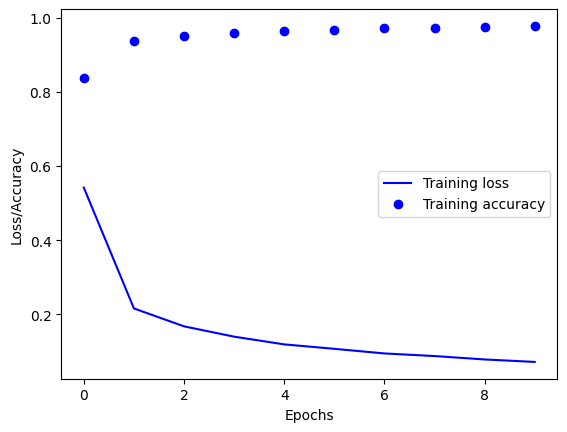

In [62]:
# Puedes usar este código para visualizar el histórico de entrenamiento
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()

❓❓❓
**EJERCICIO**

Prueba a usar el ejemplo de red neuronal convolucional disponible [aquí](https://keras.io/examples/vision/mnist_convnet/) y a realizar una evaluación similar. Explica qué observas en términos de rendimiento de clasificación y tiempo de entrenamiento.

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - accuracy: 0.7515 - loss: 0.7915 - val_accuracy: 0.9770 - val_loss: 0.0863
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.9629 - loss: 0.1243 - val_accuracy: 0.9827 - val_loss: 0.0627
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.9718 - loss: 0.0931 - val_accuracy: 0.9877 - val_loss: 0.0480
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - accuracy: 0.9776 - loss: 0.0734 - val_accuracy: 0.9877 - val_loss: 0.0450
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 78s 110ms/step - accuracy: 0.9793 - loss: 0.0650 - val_accuracy: 0.9902 - val_loss: 0.0378
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 86s 117ms/step - accuracy: 0.9821 - loss: 0.0549 - val_accuracy: 0.9890 - val_loss: 0.0403
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 125ms/step - accuracy: 0.9838 - loss: 0.0495 - val_accuracy: 0.9900 - val_loss: 0.0348
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 73s 105ms/step - accuracy: 0.9858 - loss: 0

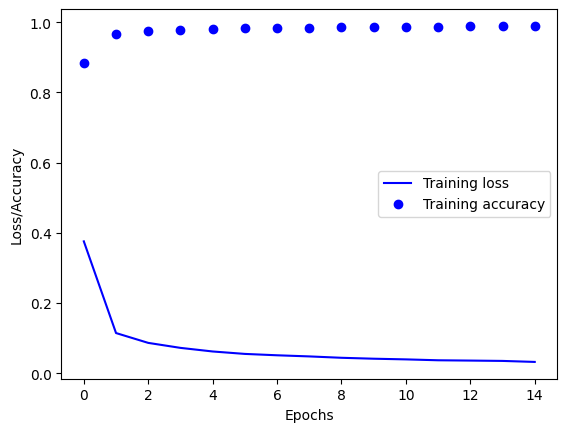

In [63]:
import numpy as np
import keras
from keras import layers

# Prepare the data
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Build the model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

# Train de model
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Visualize the training loss
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()

En cuanto al tiempo de entrenamiento, la red propuesta por keras tarda mucho más ya que tiene una mayor cantidad de parámetros que necesitan ser entrenados.

Sin embargo, la función de pérdida decae rápidamente y el accuracy sube mucho más rápido que con la red densamente conectada que propone el ejercicio.

## Resumen
* TensorFlow es un *framework* que puede ejecutarse en CPU, GPU y TPU.
* TensorFlow puede calcular el gradiente de cualquier expresión diferenciable.
* Keras es un API para hacer modelos de aprendizaje profundo con TF.
* Objetos claves de TF: tensores, variables, operaciones con tensores y *GradientTape*.
* La clase central de Keras es `Layer`, que encapsula algunos pesos y cálculos. Las capas se unen o ensamblan en **modelos**.
* Antes de entrenar un modelo es necesario elegir un **optimizador**, una **función de pérdida** y una o varias **métricas**: `model.compile()`
* El método `model.fit()` ejecuta el descenso por gradiente por mini-lotes. Permite monitorizar la pérdida y métricas y incluir datos de **validación**.
* Con el modelo entrenado, se pueden hacer predicciones con `model.predict()`.

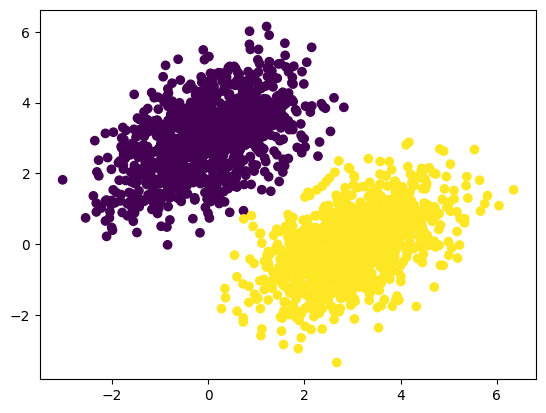

lr = 0.01
lr = 0.05
lr = 0.1
lr = 0.5
lr = 1
lr = 1.5


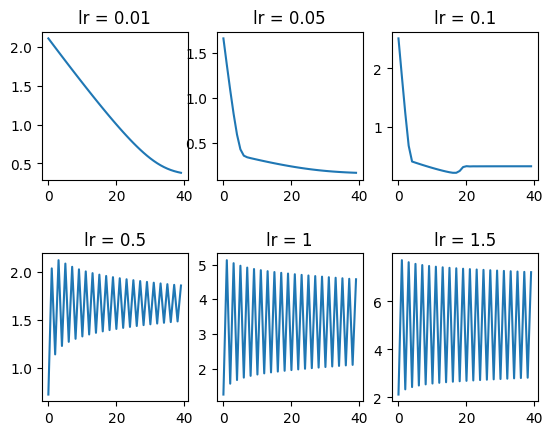

Loss at step 0: 1.7226
Loss at step 1: 1.4596
Loss at step 2: 1.2031
Loss at step 3: 0.9565
Loss at step 4: 0.7266
Loss at step 5: 0.5273
Loss at step 6: 0.3862
Loss at step 7: 0.3254
Loss at step 8: 0.3096
Loss at step 9: 0.3009
Loss at step 10: 0.2927
Loss at step 11: 0.2848
Loss at step 12: 0.2770
Loss at step 13: 0.2694
Loss at step 14: 0.2620
Loss at step 15: 0.2549
Loss at step 16: 0.2479
Loss at step 17: 0.2413
Loss at step 18: 0.2348
Loss at step 19: 0.2286
Loss at step 20: 0.2227
Loss at step 21: 0.2171
Loss at step 22: 0.2118
Loss at step 23: 0.2068
Loss at step 24: 0.2020
Loss at step 25: 0.1976
Loss at step 26: 0.1935
Loss at step 27: 0.1896
Loss at step 28: 0.1861
Loss at step 29: 0.1829
Loss at step 30: 0.1799
Loss at step 31: 0.1772
Loss at step 32: 0.1748
Loss at step 33: 0.1726
Loss at step 34: 0.1706
Loss at step 35: 0.1688
Loss at step 36: 0.1672
Loss at step 37: 0.1658
Loss at step 38: 0.1646
Loss at step 39: 0.1635


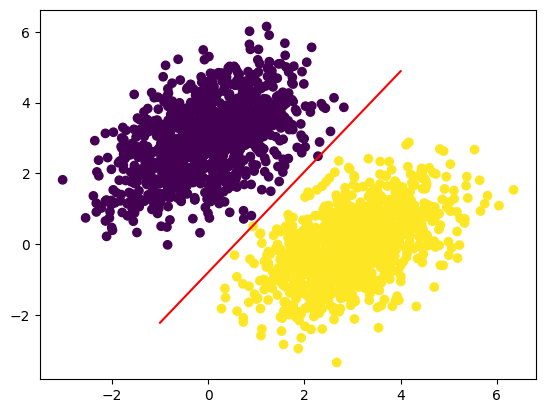

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6994 - loss: 1.0016 - val_accuracy: 0.9348 - val_loss: 0.2276
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9343 - loss: 0.2244 - val_accuracy: 0.9482 - val_loss: 0.1811
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9516 - loss: 0.1655 - val_accuracy: 0.9541 - val_loss: 0.1582
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9608 - loss: 0.1348 - val_accuracy: 0.9592 - val_loss: 0.1457
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9653 - loss: 0.1144 - val_accuracy: 0.9614 - val_loss: 0.1317
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9711 - loss: 0.1011 - val_accuracy: 0.9638 - val_loss: 0.1255
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9725 - loss: 0.0893 - val_accuracy: 0.9629 - val_loss: 0.1282
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9756 - loss: 0.0802 - val_accuracy: 0.

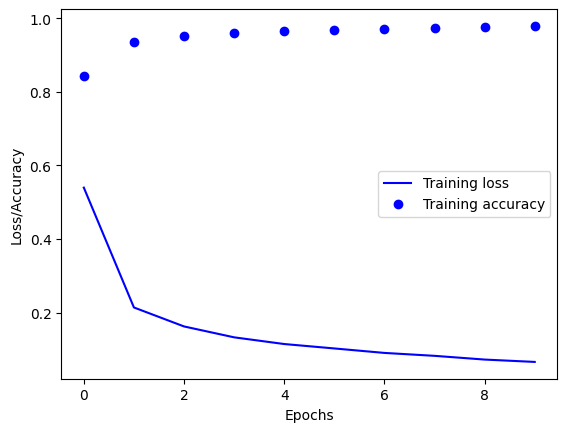

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.7779 - loss: 0.7510 - val_accuracy: 0.9780 - val_loss: 0.0790
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 97ms/step - accuracy: 0.9653 - loss: 0.1162 - val_accuracy: 0.9838 - val_loss: 0.0585
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9746 - loss: 0.0851 - val_accuracy: 0.9875 - val_loss: 0.0471
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - accuracy: 0.9776 - loss: 0.0736 - val_accuracy: 0.9885 - val_loss: 0.0428
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 97ms/step - accuracy: 0.9807 - loss: 0.0619 - val_accuracy: 0.9903 - val_loss: 0.0374
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.9828 - loss: 0.0551 - val_accuracy: 0.9883 - val_loss: 0.0400
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - accuracy: 0.9843 - loss: 0.0524 - val_accuracy: 0.9910 - val_loss: 0.0315
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9847 - loss: 0.0483 -

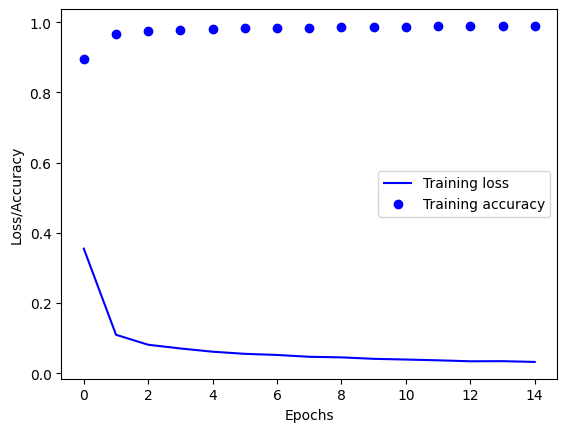

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generamos el conjunto de datos
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

# Lo mostramos
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()


## Modelo Lineal
def model(inputs):
    return tf.matmul(inputs, W) + b

def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

def rmse_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.sqrt(tf.reduce_mean(per_sample_losses))

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = rmse_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

## Ejecutamos el modelo con diferentes learning rates ##
input_dim = 2
output_dim = 1

list_learning_rate = [0.01, 0.05, 0.1, 0.5, 1, 1.5]
plot = list(list())
for learning_rate in list_learning_rate:
  print(f"lr = {learning_rate}")
  W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
  b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))
  loss_list = list()
  for step in range(40):
      loss = training_step(inputs, targets)
      loss_list.append(loss)
      #print(f"Loss at step {step}: {loss:.4f}")
  plot.append(loss_list)

# graficamos el loss en todos los learning rates
for i in range(len(plot)):
  plt.subplot(2, 3, i+1)
  plt.title(f"lr = {list_learning_rate[i]}")
  plt.subplots_adjust(hspace=0.5)
  plt.plot(plot[i])
plt.show()


# Nos quedamos con lr = 0.05
learning_rate = 0.05
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

for step in range(40):
      loss = training_step(inputs, targets)
      print(f"Loss at step {step}: {loss:.4f}")

# Predecimos los inputs y los mostramos junto con la frontera de separación
predictions = model(inputs)
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()





## Modelo de clasificacion para MNIST ##
from keras.datasets import mnist
from keras.layers import Dense

# Cargar la base de datos MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

# Modelo
model = keras.Sequential([
    Dense(32, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Paso 3: Entrenar el modelo
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

# Paso 4: Graficamos la pérdida
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()



## Modelo de CNN propuesto por Keras para MNIST ##
# Prepare the data
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Build the model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

# Train de model
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Visualize the training loss
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
